In [1]:
%%time
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import torch
import torch.utils.data as data_utils
import torch.nn as nn


CPU times: user 7.01 s, sys: 11.1 s, total: 18.1 s
Wall time: 1.55 s


In [2]:
%%time
version='v_8_2019-05-01v8'
workdir=os.getcwd()+'/'+version
os.makedirs(workdir+'/fig', exist_ok=True)
fig_dir=workdir+'/fig'
algo_name=['Old23', 'STC', 'STCth0', 'STCth10', 'STCth20', 'Thr', 'Tth0', 'Tth10', 'Tth20']
algo_name_old=['T23', 'S', 'S0', 'S10', 'S20', 'T', 'T0', 'T10', 'T20']
algo={}
for i in range(len(algo_name)):
    algo[i]=pd.read_csv(workdir+'/data/{}.csv'.format(algo_name_old[i]))

CPU times: user 54.4 s, sys: 3.52 s, total: 58 s
Wall time: 58 s


In [3]:
%%time
#cut
ptcut=10
etamin=1.6
etamax=2.9
algo_cut={}
for i in algo:
    sel=algo[i]['genpart_pt']>ptcut
    algo_cut[i]=algo[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])>etamin
    algo_cut[i]=algo_cut[i][sel]
    sel=np.abs(algo_cut[i]['genpart_exeta'])<etamax
    algo_cut[i]=algo_cut[i][sel]
    algo_cut[i].dropna(inplace=True)
    algo_cut[i]['genpart_pid'].replace([-11,11],0, inplace=True)
    algo_cut[i]['genpart_pid'].replace([-211,211],1, inplace=True)

features=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean']
from sklearn import preprocessing
sc=preprocessing.StandardScaler()
algo_norm={}
for i in algo:
    algo_norm[i]=pd.DataFrame(sc.fit_transform(algo_cut[i][features]), columns=features)
    algo_norm[i][['event', 'genpart_pid']]=algo_cut[i][['event', 'genpart_pid']]


columns=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean','cl3d_pt']
features=['cl3d_eta','cl3d_showerlength',
       'cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer', 'cl3d_szz',
       'cl3d_seetot', 'cl3d_spptot', 'cl3d_srrtot', 'cl3d_srrmean']
# Keep only relevant features and split the data between train and test
from sklearn.model_selection import train_test_split


X_train={}
X_test={}
y_train={}
y_test={}

for i in algo:
    X_train[i], X_test[i], y_train[i], y_test[i] = train_test_split(algo_cut[i][columns], pd.DataFrame(algo_cut[i]['genpart_pid']), test_size=0.2)

# keep the pt information for later
X_pt={}
for i in algo:
    X_pt[i]=X_test[i]['cl3d_pt']
    X_test[i]=X_test[i].drop(columns='cl3d_pt')
    X_train[i]=X_train[i].drop(columns='cl3d_pt')
    
columns.remove('cl3d_pt')


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/exp_soft/llr/python/3.7.0/el7/lib/p

CPU times: user 16.1 s, sys: 6.25 s, total: 22.3 s
Wall time: 22.3 s


In [9]:
def NN_AUC(loader):
    correct = 0
    total = 0
    tp= 0
    fp = 0
    target={}
    predictions={}
    target[i]=[]
    predictions[i]=[]
    for data, labels in loader:
        outputs = network(data).cpu()
        #_, predicted = torch.max(outputs.data, 1)  # Choose the best class from the output: The class with the best score
        predicted=(outputs.data > 0.5)
        predicted=predicted.cpu().float()
        total += labels.size(0)                    # Increment the total count
        #print(predicted, labels)
        correct += (predicted == labels.cpu()).sum()  # Increment the correct count
        target[i]=np.concatenate((target[i],labels.cpu().numpy()), axis=None)
        predictions[i]=np.concatenate((predictions[i], outputs.data.numpy()), axis=None)
    return predictions[i], target[i]

In [8]:
%%time
#NN parameters
torch.set_num_threads(16)
#device = torch.device("cpu")
device = torch.device("cuda:0") 

D_in =X_train[1].shape[1]  # input dimension = number of features
H1 = 16 # Hidden layer dimension
H2 = 16
D_out = 1 # Output dimension= number of classes
batch_size= 512
n_epochs = 100
learning_rate= 1e-4



import torch.utils.data as data_utils
tensor_train={}
tensor_test={}
loader_train={}
loader_test={}

for i in [0,1,5]:
    
    tensor_train[i] = data_utils.TensorDataset(torch.tensor(X_train[i].values, dtype=torch.float, device=device), torch.tensor(y_train[i].values, dtype=torch.float, device=device))
    tensor_test[i] = data_utils.TensorDataset(torch.tensor(X_test[i].values, dtype=torch.float, device=device), torch.tensor(y_test[i].values, dtype=torch.float, device=device))
    loader_train[i] = data_utils.DataLoader(tensor_train[i], batch_size=batch_size, shuffle=False)
    loader_test[i] = data_utils.DataLoader(tensor_test[i], batch_size=batch_size, shuffle=False)
    


CPU times: user 2.9 s, sys: 872 ms, total: 3.77 s
Wall time: 427 ms


# NN 

In [14]:
%%time
import torch.nn as nn

y_pred={}
train_losses = []
train_counter = []
early_stop=5  #number of epochs without gaining AUC before stoping
predictions_NN={}
target={}

network = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),     
    torch.nn.LeakyReLU(0.05),                              
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(0.03),
    torch.nn.Linear(H2,D_out),
    torch.nn.Sigmoid()
    
     )
network.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

for i in [0,1,5]:
    network = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),     
    torch.nn.LeakyReLU(0.05),                              
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(0.03),
    torch.nn.Linear(H2,D_out),
    torch.nn.Sigmoid()
    
     )
    network.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
        best_AUC=0
        counter=0

    for epoch in range(n_epochs):
        for j, (data, labels) in enumerate(loader_train[i]): 
            optimizer.zero_grad()                             # Intialize the hidden weight to all zeros
            y_pred[i] = network(data)                             # Forward pass: compute the output class 
            loss = criterion(y_pred[i], labels)                 # Compute the loss: difference between the output class and the pre-given label
            loss.backward()                                   # Backward pass: compute the weight
            optimizer.step()                                  # Optimizer: update the weights of hidden nodes

            if (j+1) % 2000 == 0:                              # Logging
                print('Algo %s :Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                     %(algo_name[i],epoch+1, n_epochs, j+1, len(tensor_train[i])//batch_size, loss.item()))

            if (j+1) % 100 == 0:                              # keep track of loss value
                train_losses.append(loss.item())
                train_counter.append(((j+1)*batch_size) + ((epoch)*len(loader_train[i].dataset)))
                
        predictions_NN[i], target[i]=NN_AUC(loader_test[i])
        fpr, tpr, threshold = metrics.roc_curve(target[i],predictions_NN[i])
        roc_auc = metrics.auc(fpr, tpr)
        print('Epoch {}: AUC= {}'.format(epoch+1,roc_auc))
        if roc_auc>best_AUC:
            best_AUC=roc_auc
        else : counter+=1
        if counter==early_stop:
            print('Stopped at epoch {}, AUC score= {}'.format(epoch+1,roc_auc))
            break


    predictions_NN[i], target[i]=NN_AUC(loader_test[i])
    
    

Algo Old23 :Epoch [1/100], Step [2000/2930], Loss: 0.0817
Epoch 1: AUC= 0.9706154517465216
Algo Old23 :Epoch [2/100], Step [2000/2930], Loss: 0.0644
Epoch 2: AUC= 0.9794246668880094
Algo Old23 :Epoch [3/100], Step [2000/2930], Loss: 0.0585
Epoch 3: AUC= 0.9838365934252526
Algo Old23 :Epoch [4/100], Step [2000/2930], Loss: 0.0529
Epoch 4: AUC= 0.9854100779821491
Algo Old23 :Epoch [5/100], Step [2000/2930], Loss: 0.0494
Epoch 5: AUC= 0.9862815419291777
Algo Old23 :Epoch [6/100], Step [2000/2930], Loss: 0.0475
Epoch 6: AUC= 0.9868203256216791
Algo Old23 :Epoch [7/100], Step [2000/2930], Loss: 0.0462
Epoch 7: AUC= 0.9872175435225075
Algo Old23 :Epoch [8/100], Step [2000/2930], Loss: 0.0453
Epoch 8: AUC= 0.9875228572137581
Algo Old23 :Epoch [9/100], Step [2000/2930], Loss: 0.0446
Epoch 9: AUC= 0.9877624224823709
Algo Old23 :Epoch [10/100], Step [2000/2930], Loss: 0.0441
Epoch 10: AUC= 0.9879677098619188
Algo Old23 :Epoch [11/100], Step [2000/2930], Loss: 0.0437
Epoch 11: AUC= 0.988160765525

Algo STC :Epoch [46/100], Step [2000/2937], Loss: 0.0215
Epoch 46: AUC= 0.9877850535317823
Algo STC :Epoch [47/100], Step [2000/2937], Loss: 0.0215
Epoch 47: AUC= 0.9877945620830137
Algo STC :Epoch [48/100], Step [2000/2937], Loss: 0.0215
Epoch 48: AUC= 0.9878116255625815
Algo STC :Epoch [49/100], Step [2000/2937], Loss: 0.0214
Epoch 49: AUC= 0.9878244575641857
Algo STC :Epoch [50/100], Step [2000/2937], Loss: 0.0214
Epoch 50: AUC= 0.987841448951817
Algo STC :Epoch [51/100], Step [2000/2937], Loss: 0.0214
Epoch 51: AUC= 0.9878529689769998
Algo STC :Epoch [52/100], Step [2000/2937], Loss: 0.0214
Epoch 52: AUC= 0.987866561958009
Algo STC :Epoch [53/100], Step [2000/2937], Loss: 0.0214
Epoch 53: AUC= 0.9878790465305385
Algo STC :Epoch [54/100], Step [2000/2937], Loss: 0.0213
Epoch 54: AUC= 0.9878908712218119
Algo STC :Epoch [55/100], Step [2000/2937], Loss: 0.0213
Epoch 55: AUC= 0.9878997413943068
Algo STC :Epoch [56/100], Step [2000/2937], Loss: 0.0213
Epoch 56: AUC= 0.9879119715270807
A

Epoch 36: AUC= 0.9901409843284565
Algo Thr :Epoch [37/100], Step [2000/2936], Loss: 0.0489
Epoch 37: AUC= 0.9901482133073053
Algo Thr :Epoch [38/100], Step [2000/2936], Loss: 0.0490
Epoch 38: AUC= 0.9901540492632894
Algo Thr :Epoch [39/100], Step [2000/2936], Loss: 0.0489
Epoch 39: AUC= 0.9901628819865134
Algo Thr :Epoch [40/100], Step [2000/2936], Loss: 0.0489
Epoch 40: AUC= 0.9901752478955775
Algo Thr :Epoch [41/100], Step [2000/2936], Loss: 0.0490
Epoch 41: AUC= 0.9901810778171541
Algo Thr :Epoch [42/100], Step [2000/2936], Loss: 0.0490
Epoch 42: AUC= 0.990185318316016
Algo Thr :Epoch [43/100], Step [2000/2936], Loss: 0.0490
Epoch 43: AUC= 0.9901892338016881
Algo Thr :Epoch [44/100], Step [2000/2936], Loss: 0.0490
Epoch 44: AUC= 0.9901954469483725
Algo Thr :Epoch [45/100], Step [2000/2936], Loss: 0.0490
Epoch 45: AUC= 0.9902029094990219
Algo Thr :Epoch [46/100], Step [2000/2936], Loss: 0.0490
Epoch 46: AUC= 0.9902095848410941
Algo Thr :Epoch [47/100], Step [2000/2936], Loss: 0.0489


# BDT

In [6]:
%%time
train={}
test={}

for i in [0,1,5]:
    train[i] = xgb.DMatrix(data=X_train[i],label=y_train[i], feature_names=columns)
    test[i] = xgb.DMatrix(data=X_test[i],label=y_test[i],feature_names=columns)

param = {}

# Booster parameters
param['nthread']          = 30  # limit number of threads
param['eta']              = 0.2 # learning rate
param['max_depth']        = 4  # maximum depth of a tree
param['subsample']        = 0.8 # fraction of events to train tree on
param['colsample_bytree'] = 0.8 # fraction of features to train tree on
param['silent'] = True

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')] + [('eval_metric', 'rmse')]

num_trees = 81  # number of trees to make



booster={}
for i in [0,1,5]:
    booster[i] = xgb.train(param,train[i],num_boost_round=num_trees);
    
predictions_BDT={}
for i in [0,1,5]:
    print(algo_name[i],'\t',booster[i].eval(test[i]))
    predictions_BDT[i]=booster[i].predict(test[i])

Old23 	 [0]	eval-error:0.009775	eval-logloss:0.033666	eval-rmse:0.088852
STC 	 [0]	eval-error:0.013845	eval-logloss:0.045591	eval-rmse:0.105761
Thr 	 [0]	eval-error:0.011629	eval-logloss:0.039425	eval-rmse:0.097031
CPU times: user 18min 44s, sys: 5.12 s, total: 18min 49s
Wall time: 58.7 s


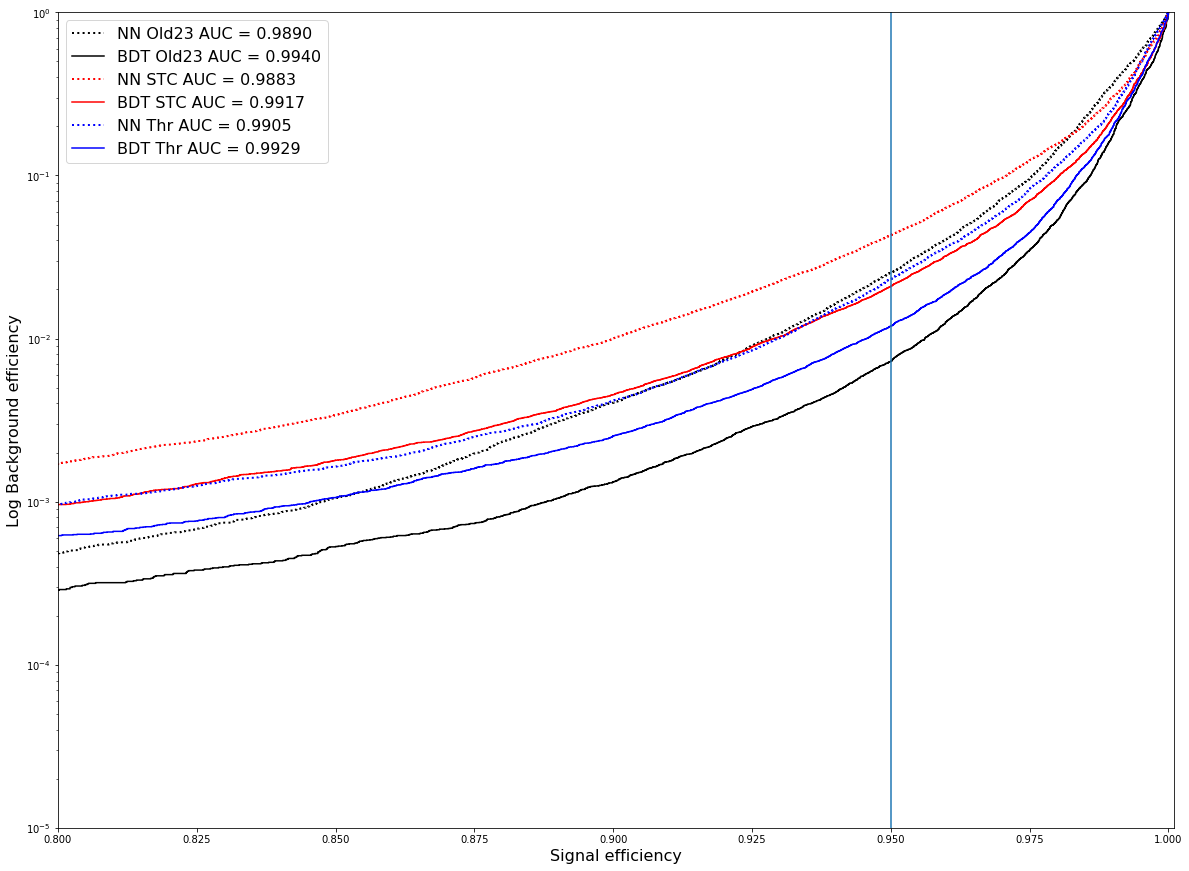

In [19]:
plt.figure(figsize=(20,15))
color=['k','red','','','','blue','','blue']
for i in [0,1,5]:
    
   
    fpr, tpr, threshold = metrics.roc_curve(target[i],predictions_NN[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,fpr, label ='NN %s AUC = %0.4f' %(algo_name[i],roc_auc), linestyle=':', c=color[i],linewidth=2)
    
    fpr, tpr, threshold = metrics.roc_curve(y_test[i],predictions_BDT[i])
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(tpr,fpr, label ='BDT %s AUC = %0.4f' %(algo_name[i],roc_auc), linestyle='-', c=color[i])
    
plt.legend( fontsize=16)
    #plt.plot([0, 1], [0, 1],'r--')
plt.xlim(0.8,1.001)
plt.yscale('log')
plt.ylim(0.00001,1)
plt.axvline(x=0.950, label='0.95 WP')
plt.xlabel('Signal efficiency', fontsize=16)
plt.ylabel('Log Background efficiency', fontsize=16) 
plt.savefig(fig_dir+'/NN-BDT.png')